<a href="https://colab.research.google.com/github/AnnPike/final-project-ML/blob/master/nets_to_compurte_smoothness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
save_to = "/content/gdrive/My Drive/nets_to_compute_smoothness/"

# Loadind data and function defininitions

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience or if training loss doesn't improve after a given t_patience"""
    def __init__(self, patience=5, t_patience=5, verbose=False, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            t_patience  (int): How long to wait after train loss is not improving
                            Deafault: 10
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.t_patience = t_patience
        self.verbose = verbose
        self.counter = 0
        self.t_counter = 0
        self.best_score = None
        self.t_last_best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.path = path

    def __call__(self, val_loss, train_loss, model):

        score = val_loss
        t_score = train_loss
        if self.t_counter < self.t_patience:
          if self.t_last_best_score is None:
            self.t_last_best_score = t_score
          elif t_score < self.t_last_best_score:
            self.t_last_best_score = t_score
            self.t_counter += 1
          else:
            self.t_counter = 0
            self.t_last_best_score = t_score

        if self.t_counter == self.t_patience:
          if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
          elif score > self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
              self.early_stop = True
          else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0


    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
import torch
import numpy as np
import time

from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose
from torchvision.transforms import Normalize



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

batch_size = 250
valid_size = 0.2
transform = Compose([ToTensor(), Normalize((0.4914, 0.4822, 0.4465), (1,1,1))])

train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

all_train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

num_train = len(train_data)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

cuda:0


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
num_epochs = 100
patience = 5 

#train model with early stopping
def train_model(model, batch_size, patience, num_epochs, model_name, verbose=False):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(verbose=False)
    
    for epoch in range(1, num_epochs + 1):
        model_save_name = model_name+'.pt'

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            data = data.to(device)
            target = target.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        with torch.no_grad():
          for data, target in valid_loader:
              data = data.to(device)
              target = target.to(device)
              # forward pass: compute predicted outputs by passing inputs to the model
              output = model(data)
              # calculate the loss
              loss = criterion(output, target)
              # record validation loss
              valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        if verbose:
          epoch_len = len(str(num_epochs))
          print_msg = (f'[{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
                      f'train_loss: {train_loss:.5f} ' +
                      f'valid_loss: {valid_loss:.5f}')
          print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, train_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        torch.save(model.state_dict(), save_to+model_name+'_'+str(epoch))

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))   
    path = save_to+model_save_name
    torch.save(model.state_dict(), path)

    # plot learning curves
    E = epoch-patience
    print(F"epochs: {E}")
    plt.plot(range(1,epoch+1),avg_train_losses,'y',label = 'average train loss per batch')
    plt.plot(range(1,epoch+1),avg_valid_losses,'b', label = 'average valid loss per batch')   
    plt.axvline(x=E, color ='r', linestyle ="--", linewidth = 1, label = 'early stopping')
    plt.xlabel('# epochs')
    plt.ylabel('Cross Entropy Loss')
    plt.legend()
    plt.show()
    return  model

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

def eval_model(model):
  PREDICT = torch.empty(0).to(device)
  CORRECT = torch.empty(0).to(device)
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  model.eval()
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)
       # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      loss = criterion(output, target)
      _, pred = torch.max(output,1)
      PREDICT = torch.cat([PREDICT,pred],axis=0)
      CORRECT = torch.cat([CORRECT,target],axis=0)

  cf_matrix = confusion_matrix(CORRECT.cpu(), PREDICT.cpu())
  cf_matrix_pc = (cf_matrix/cf_matrix.sum(axis=0))*100
  sns.heatmap(cf_matrix_pc, annot=True,cmap='Blues', xticklabels=classes, yticklabels=classes)
  plt.title('confusuin matrix for test predictions in percent')
  plt.show()
  accuracy = accuracy_score(CORRECT.cpu(), PREDICT.cpu())
  precision, recall, _, __ = precision_recall_fscore_support(CORRECT.cpu(), PREDICT.cpu(), average='macro')
  print(f"Macro precision: {precision:.4f}\nMacro recall: {recall:.4f}\nAccuracy: {accuracy*100:.2f} %")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# ResNet12

Early stopping
epochs: 30


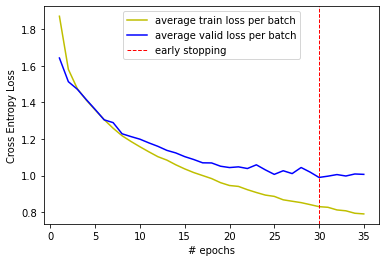

--- 6.875734281539917 minuts ---


In [ ]:
model_name = 'ResNet12'
class ResNet12(nn.Module):
  def __init__(self):
    super(ResNet12,self).__init__()
    self.conv1 = nn.Conv2d(3, 4, 4, padding=1,stride=2, bias=False)
    self.conv2 = nn.Conv2d(4, 4, 3, padding=1, bias=False)
    self.conv3 = nn.Conv2d(4, 4, 3, padding=1, bias=False)
    self.conv4 = nn.Conv2d(4, 8, 3, padding=1, bias=False)
    self.conv5 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv6 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv7 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv8 = nn.Conv2d(8, 16, 3, padding=1, bias=False)
    self.conv9 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.conv10 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.conv11 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*16,10)
  def forward(self, x):
    padding_zeros_4 = torch.zeros(batch_size,4,16,16).to(device)
    padding_zeros_8 = torch.zeros(batch_size,8,16,16).to(device)
    x = self.conv1(x) #4*16*16
    identity = x.clone()
    x = F.relu(x)
    x = F.relu(self.conv2(x)) 
    x = self.conv3(x)
    x = x + identity
    identity = x.clone()
    x = F.relu(x)
    x = F.relu(self.conv4(x)) #8*16*16
    x = self.conv5(x) 
    x = x + torch.cat([identity,padding_zeros_4],axis=1)
    identity = x.clone()
    x = F.relu(x)
    x = F.relu(self.conv6(x)) 
    x = self.conv7(x)
    x = x + identity
    identity = x.clone() 
    x = F.relu(x)
    x = F.relu(self.conv8(x)) #16
    x = self.conv9(x) 
    x = x + torch.cat([identity,padding_zeros_8],axis=1)
    identity = x.clone() 
    x = F.relu(x)
    x = F.relu(self.conv10(x))
    x = self.conv11(x)
    x = x+identity
    x = F.relu(x)
    x = self.avpool(x)
    x = x.view(-1,8*8*16)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet12()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

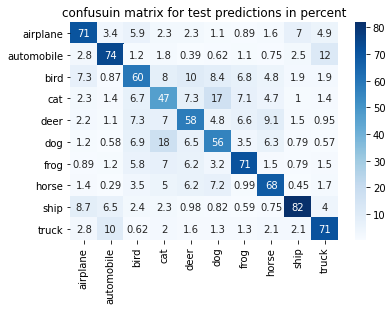

Macro precision: 0.6583
Macro recall: 0.6563
Accuracy: 65.63 %


In [ ]:
eval_model(model)

epoch 5 of ResNet12


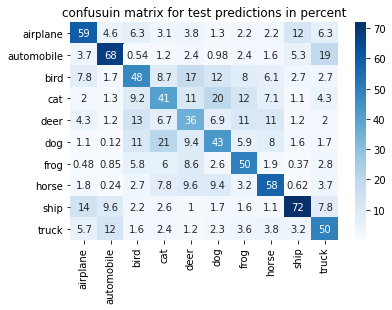

Macro precision: 0.5236
Macro recall: 0.5168
Accuracy: 51.68 %


In [ ]:
model = ResNet12()
model.load_state_dict(torch.load(save_to + model_name + '_5' ))
print('epoch 5 of ResNet12')
eval_model(model.to(device))

# ResNet10_conv2

Early stopping
epochs: 37


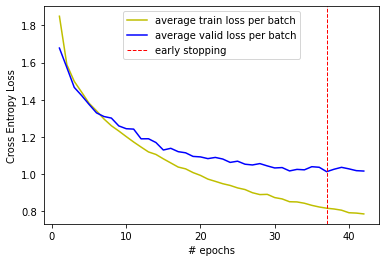

--- 10.21166737874349 minuts ---


In [ ]:
model_name = 'ResNet10_conv2'
class ResNet10(nn.Module):
  def __init__(self):
    super(ResNet10,self).__init__()
    self.conv1 = nn.Conv2d(3, 4, 4, padding=1,stride=2, bias=False)
    self.conv2 = nn.Conv2d(4, 8, 3, padding=1, bias=False)
    self.conv3 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv4 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv5 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    # self.conv6 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    # self.conv7 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv8 = nn.Conv2d(8, 16, 3, padding=1, bias=False)
    self.conv9 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.conv10 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.conv11 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*16,10)
  def forward(self, x):
    padding_zeros_4 = torch.zeros(batch_size,4,16,16).to(device)
    padding_zeros_8 = torch.zeros(batch_size,8,16,16).to(device)
    x = self.conv1(x) #4*16*16
    identity = x.clone()
    x = F.relu(x)
    x = F.relu(self.conv2(x)) #8
    x = self.conv3(x)
    x = x + torch.cat([identity,padding_zeros_4],axis=1)
    identity = x.clone()
    x = F.relu(x)
    x = F.relu(self.conv4(x)) 
    x = self.conv5(x) 
    x = x + identity
    identity = x.clone()
    x = F.relu(x)
    # x = F.relu(self.conv6(x)) 
    # x = self.conv7(x)
    # x = x + identity
    # identity = x.clone() 
    # x = F.relu(x)
    x = F.relu(self.conv8(x)) #16
    x = self.conv9(x) 
    x = x + torch.cat([identity,padding_zeros_8],axis=1)
    identity = x.clone() 
    x = F.relu(x)
    x = F.relu(self.conv10(x))
    x = self.conv11(x)
    x = x+identity
    x = F.relu(x)
    x = self.avpool(x)
    x = x.view(-1,8*8*16)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet10()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

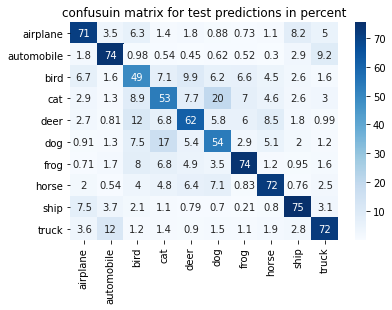

Macro precision: 0.6564
Macro recall: 0.6576
Accuracy: 65.76 %


In [ ]:
eval_model(model)

# ResNet10_conv2_noavpool

Early stopping
epochs: 22


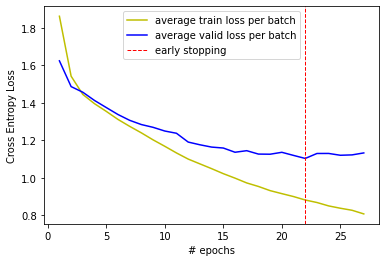

--- 7.743471992015839 minuts ---


In [ ]:
model_name = 'ResNet10_conv2_noavpool'
class ResNet10(nn.Module):
  def __init__(self):
    super(ResNet10,self).__init__()
    self.conv1 = nn.Conv2d(3, 4, 4, padding=1,stride=2, bias=False)
    self.conv2 = nn.Conv2d(4, 8, 3, padding=1, bias=False)
    self.conv3 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv4 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv5 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    # self.conv6 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    # self.conv7 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv8 = nn.Conv2d(8, 16, 3, padding=1, bias=False)
    self.conv9 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.conv10 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.conv11 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.fc1 = nn.Linear(16*16*16,10)
  def forward(self, x):
    padding_zeros_4 = torch.zeros(batch_size,4,16,16).to(device)
    padding_zeros_8 = torch.zeros(batch_size,8,16,16).to(device)
    x = self.conv1(x) #4*16*16
    identity = x.clone()
    x = F.relu(x)
    x = F.relu(self.conv2(x)) #8
    x = self.conv3(x)
    x = x + torch.cat([identity,padding_zeros_4],axis=1)
    identity = x.clone()
    x = F.relu(x)
    x = F.relu(self.conv4(x)) 
    x = self.conv5(x) 
    x = x + identity
    identity = x.clone()
    x = F.relu(x)
    # x = F.relu(self.conv6(x)) 
    # x = self.conv7(x)
    # x = x + identity
    # identity = x.clone() 
    # x = F.relu(x)
    x = F.relu(self.conv8(x)) #16
    x = self.conv9(x) 
    x = x + torch.cat([identity,padding_zeros_8],axis=1)
    identity = x.clone() 
    x = F.relu(x)
    x = F.relu(self.conv10(x))
    x = self.conv11(x)
    x = x+identity
    x = F.relu(x)
    x = x.view(-1,16*16*16)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet10()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0005)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

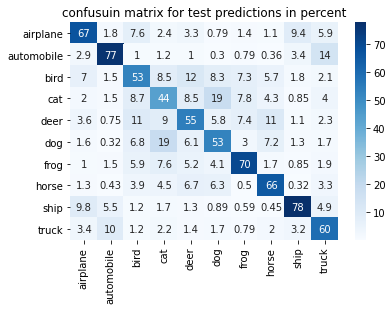

Macro precision: 0.6224
Macro recall: 0.6222
Accuracy: 62.22 %


In [ ]:
eval_model(model)

# Plain12

Early stopping
epochs: 44


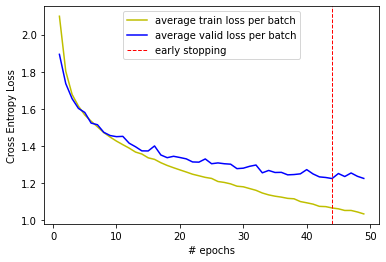

--- 10.072444995244345 minuts ---


In [ ]:
model_name = 'Plain12'
class Plain12(nn.Module):
  def __init__(self):
    super(Plain12,self).__init__()
    self.conv1 = nn.Conv2d(3, 4, 4, padding=1,stride=2, bias=False)
    self.conv2 = nn.Conv2d(4, 4, 3, padding=1, bias=False)
    self.conv3 = nn.Conv2d(4, 4, 3, padding=1, bias=False)
    self.conv4 = nn.Conv2d(4, 8, 3, padding=1, bias=False)
    self.conv5 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv6 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv7 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv8 = nn.Conv2d(8, 16, 3, padding=1, bias=False)
    self.conv9 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.conv10 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.conv11 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*16,10)
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x)) 
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = F.relu(self.conv7(x))
    x = F.relu(self.conv8(x))
    x = F.relu(self.conv9(x))
    x = F.relu(self.conv10(x))
    x = F.relu(self.conv11(x))
    x = self.avpool(x)
    x = x.view(-1,8*8*16)
    x = self.fc1(x)
    return x #10 class scores

model = Plain12()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

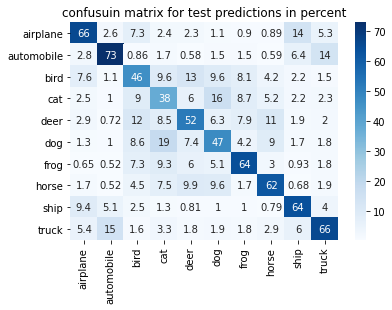

Macro precision: 0.5784
Macro recall: 0.5740
Accuracy: 57.40 %


In [ ]:
eval_model(model)

epoch 5 of Plain12


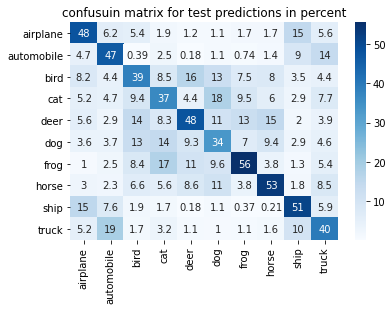

Macro precision: 0.4515
Macro recall: 0.4495
Accuracy: 44.95 %


In [ ]:
model = Plain12()
model.load_state_dict(torch.load(save_to + model_name + '_5' ))
print('epoch 5 of Plain12')
eval_model(model.to(device))

# Plain6

Early stopping
epochs: 39


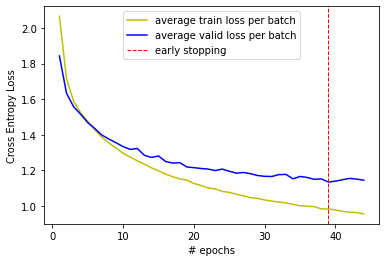

--- 9.788434227307638 minuts ---


In [ ]:
model_name = 'Plain6'
class Plain6(nn.Module):
  def __init__(self):
    super(Plain6,self).__init__()
    self.conv1 = nn.Conv2d(3, 4, 4, padding=1,stride=2, bias=False)
    self.conv2 = nn.Conv2d(4, 4, 3, padding=1, bias=False)
    self.conv3 = nn.Conv2d(4, 4, 3, padding=1, bias=False)
    self.conv4 = nn.Conv2d(4, 16, 3, padding=1, bias=False)
    # self.conv5 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    # self.conv6 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    # self.conv7 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    # self.conv8 = nn.Conv2d(8, 16, 3, padding=1, bias=False)
    # self.conv9 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    # self.conv10 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.conv11 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*16,10)
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x)) 
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    # x = F.relu(self.conv5(x))
    # x = F.relu(self.conv6(x))
    # x = F.relu(self.conv7(x))
    # x = F.relu(self.conv8(x))
    # x = F.relu(self.conv9(x))
    # x = F.relu(self.conv10(x))
    x = F.relu(self.conv11(x))
    x = self.avpool(x)
    x = x.view(-1,8*8*16)
    x = self.fc1(x)
    return x #10 class scores

model = Plain6()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

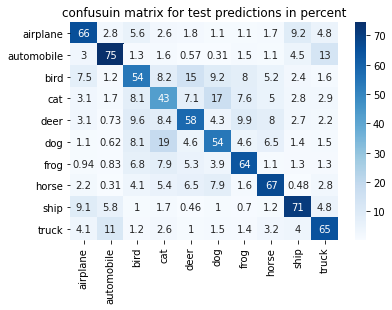

Macro precision: 0.6162
Macro recall: 0.6178
Accuracy: 61.78 %


In [ ]:
eval_model(model)

# Plain6_noavpool

Early stopping
epochs: 24


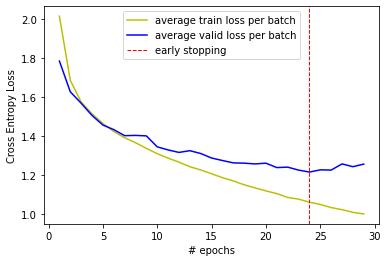

--- 7.106727345784505 minuts ---


In [ ]:
model_name = 'Plain6_noavpool'
class Plain6(nn.Module):
  def __init__(self):
    super(Plain6,self).__init__()
    self.conv1 = nn.Conv2d(3, 4, 4, padding=1,stride=2, bias=False)
    self.conv2 = nn.Conv2d(4, 4, 3, padding=1, bias=False)
    self.conv3 = nn.Conv2d(4, 4, 3, padding=1, bias=False)
    self.conv4 = nn.Conv2d(4, 16, 3, padding=1, bias=False)
    # self.conv5 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    # self.conv6 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    # self.conv7 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    # self.conv8 = nn.Conv2d(8, 16, 3, padding=1, bias=False)
    # self.conv9 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    # self.conv10 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.conv11 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.fc1 = nn.Linear(16*16*16,10)
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x)) 
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    # x = F.relu(self.conv5(x))
    # x = F.relu(self.conv6(x))
    # x = F.relu(self.conv7(x))
    # x = F.relu(self.conv8(x))
    # x = F.relu(self.conv9(x))
    # x = F.relu(self.conv10(x))
    x = F.relu(self.conv11(x))
    x = x.view(-1,16*16*16)
    x = self.fc1(x)
    return x #10 class scores

model = Plain6()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

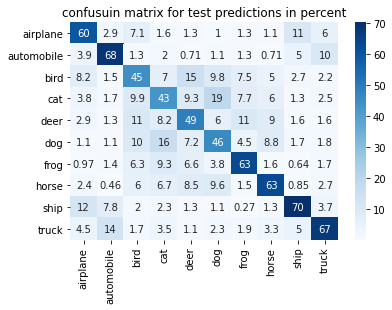

Macro precision: 0.5750
Macro recall: 0.5776
Accuracy: 57.76 %


In [ ]:
eval_model(model)

# ResNet12 1 block

Early stopping
epochs: 43


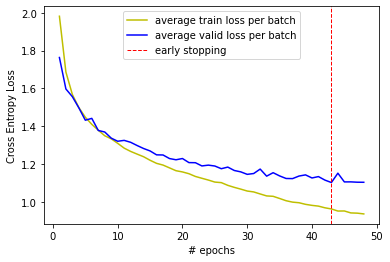

--- 8.80247288942337 minuts ---


In [ ]:
model_name = 'ResNet12_1b'
class ResNet12_1b(nn.Module):
  def __init__(self):
    super(ResNet12_1b,self).__init__()
    self.conv1 = nn.Conv2d(3, 4, 4, padding=1,stride=2, bias=False)
    self.conv2 = nn.Conv2d(4, 4, 3, padding=1, bias=False)
    self.conv3 = nn.Conv2d(4, 4, 3, padding=1, bias=False)
    self.conv4 = nn.Conv2d(4, 8, 3, padding=1, bias=False)
    self.conv5 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv6 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv7 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv8 = nn.Conv2d(8, 16, 3, padding=1, bias=False)
    self.conv9 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.conv10 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.conv11 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*16,10)
  def forward(self, x):
    padding_zeros_12 = torch.zeros(batch_size,12,16,16).to(device)
    x = self.conv1(x) #4*16*16
    identity = x.clone()
    x = F.relu(x)
    x = F.relu(self.conv2(x)) 
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x)) 
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x)) 
    x = F.relu(self.conv7(x))
    x = F.relu(self.conv8(x)) #16*16*16
    x = F.relu(self.conv9(x))
    x = F.relu(self.conv10(x))
    x = self.conv11(x)
    x = x + torch.cat([identity,padding_zeros_12],axis=1)
    x = F.relu(x)
    x = self.avpool(x)
    x = x.view(-1,8*8*16)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet12_1b()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

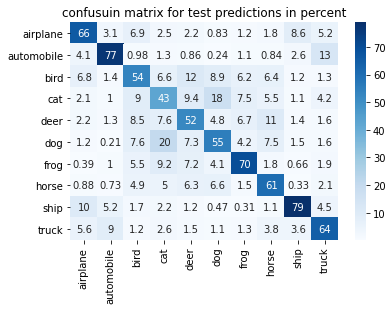

Macro precision: 0.6215
Macro recall: 0.6199
Accuracy: 61.99 %


In [ ]:
eval_model(model, model_name)

# ResNet12 bottleback

Early stopping
epochs: 41


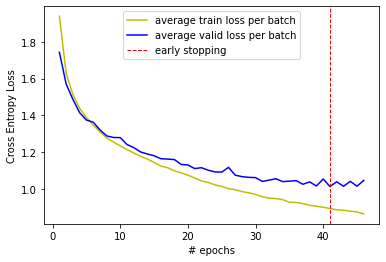

--- 8.27130880355835 minuts ---


In [ ]:
model_name = 'ResNet12_bottleback'
class ResNet12_bottleback(nn.Module):
  def __init__(self):
    super(ResNet12_bottleback,self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 4, padding=1,stride=2, bias=False)
    self.conv2 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.conv3 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.conv4 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.conv5 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.conv6 = nn.Conv2d(16, 8, 3, padding=1, bias=False)
    self.conv7 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv8 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv9 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv10 = nn.Conv2d(8, 4, 3, padding=1, bias=False)
    self.conv11 = nn.Conv2d(4, 4, 3, padding=1, bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*4,10)
  def forward(self, x):
    x = self.conv1(x) #16*16*16
    identity = x.clone()
    x = F.relu(x)
    x = F.relu(self.conv2(x)) 
    x = self.conv3(x)
    x = x + identity
    identity = x.clone()
    x = F.relu(x)
    x = F.relu(self.conv4(x)) 
    x = x + identity
    identity = x.clone()
    x = F.relu(x)
    x = F.relu(self.conv6(x)) #8*16*16 
    x = self.conv7(x)
    x = x + identity[:,:8]
    identity = x.clone() 
    x = F.relu(x)
    x = F.relu(self.conv8(x)) 
    x = self.conv9(x) 
    x = x + identity
    identity = x.clone() 
    x = F.relu(x)
    x = F.relu(self.conv10(x)) #4*16*16
    x = self.conv11(x)
    x = x+identity[:,:4]
    x = F.relu(x)
    x = self.avpool(x)
    x = x.view(-1,8*8*4)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet12_bottleback()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

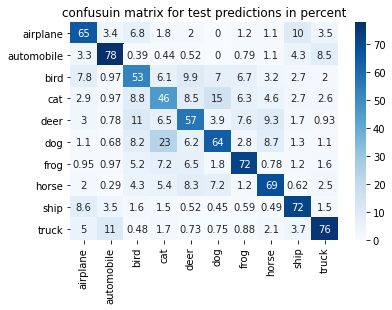

Macro precision: 0.6511
Macro recall: 0.6498
Accuracy: 64.98 %


In [ ]:
eval_model(model, model_name)

# ResNet12 tangh

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Early stopping
epochs: 37


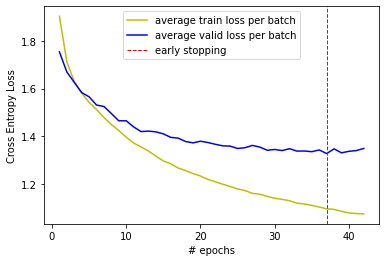

--- 8.846016915639241 minuts ---


In [ ]:
model_name = 'ResNet12_tangh'
class ResNet12_tangh(nn.Module):
  def __init__(self):
    super(ResNet12_tangh,self).__init__()
    self.conv1 = nn.Conv2d(3, 4, 4, padding=1, stride=2, bias=False)
    self.conv2 = nn.Conv2d(4, 4, 3, padding=1, bias=False)
    self.conv3 = nn.Conv2d(4, 4, 3, padding=1, bias=False)
    self.conv4 = nn.Conv2d(4, 8, 3, padding=1, bias=False)
    self.conv5 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv6 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv7 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv8 = nn.Conv2d(8, 16, 3, padding=1, bias=False)
    self.conv9 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.conv10 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.conv11 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*16,10)
  def forward(self, x):
    padding_zeros_4 = torch.zeros(batch_size,4,16,16).to(device)
    padding_zeros_8 = torch.zeros(batch_size,8,16,16).to(device)
    x = self.conv1(x) #4*16*16
    identity = x.clone()
    x = F.tanh(x)
    x = F.tanh(self.conv2(x)) 
    x = self.conv3(x)
    x = x + identity
    identity = x.clone()
    x = F.tanh(x)
    x = F.tanh(self.conv4(x)) #8*16*16
    x = self.conv5(x) 
    x = x + torch.cat([identity,padding_zeros_4],axis=1)
    identity = x.clone()
    x = F.tanh(x)
    x = F.tanh(self.conv6(x)) 
    x = self.conv7(x)
    x = x + identity
    identity = x.clone() 
    x = F.tanh(x)
    x = F.tanh(self.conv8(x)) #16
    x = self.conv9(x) 
    x = x + torch.cat([identity,padding_zeros_8],axis=1)
    identity = x.clone() 
    x = F.tanh(x)
    x = F.tanh(self.conv10(x))
    x = self.conv11(x)
    x = x+identity
    x = F.tanh(x)
    x = self.avpool(x)
    x = x.view(-1,8*8*16)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet12_tangh()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


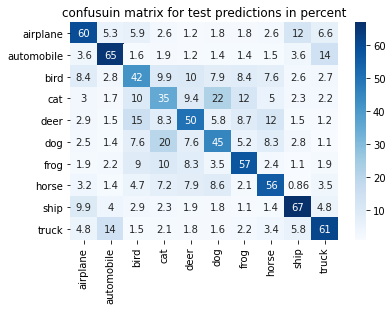

Macro precision: 0.5396
Macro recall: 0.5434
Accuracy: 54.34 %


In [ ]:
eval_model(model)

# ResNet9 tangh

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Early stopping
epochs: 37


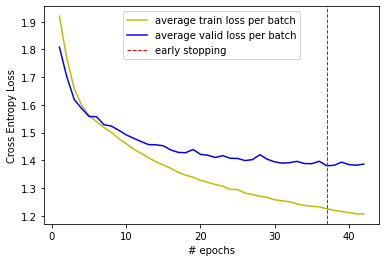

--- 10.077158749103546 minuts ---


In [ ]:
model_name = 'ResNet9_tangh'
class ResNet9_tangh(nn.Module):
  def __init__(self):
    super(ResNet9_tangh,self).__init__()
    self.conv1 = nn.Conv2d(3, 4, 4, padding=1, stride=2, bias=False)
    self.conv2 = nn.Conv2d(4, 4, 3, padding=1, bias=False)
    self.conv3 = nn.Conv2d(4, 4, 3, padding=1, bias=False)
    self.conv4 = nn.Conv2d(4, 8, 3, padding=1, bias=False)
    self.conv5 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv6 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv7 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv8 = nn.Conv2d(8, 16, 3, padding=1, bias=False)
    # self.conv9 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    # self.conv10 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    # self.conv11 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*16,10)
  def forward(self, x):
    padding_zeros_4 = torch.zeros(batch_size,4,16,16).to(device)
    padding_zeros_8 = torch.zeros(batch_size,8,16,16).to(device)
    x = self.conv1(x) #4*16*16
    identity = x.clone()
    x = F.tanh(x)
    x = F.tanh(self.conv2(x)) 
    x = self.conv3(x)
    x = x + identity
    identity = x.clone()
    x = F.tanh(x)
    x = F.tanh(self.conv4(x)) #8*16*16
    x = self.conv5(x) 
    x = x + torch.cat([identity,padding_zeros_4],axis=1)
    identity = x.clone()
    x = F.tanh(x)
    x = F.tanh(self.conv6(x)) 
    x = self.conv7(x)
    x = x + identity
    identity = x.clone() 
    x = F.tanh(x)
    x = F.tanh(self.conv8(x)) #16
    # x = self.conv9(x) 
    # x = x + torch.cat([identity,padding_zeros_8],axis=1)
    # identity = x.clone() 
    # x = F.tanh(x)
    # x = F.tanh(self.conv10(x))
    # x = self.conv11(x)
    # x = x+identity
    # x = F.tanh(x)
    x = self.avpool(x)
    x = x.view(-1,8*8*16)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet9_tangh()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


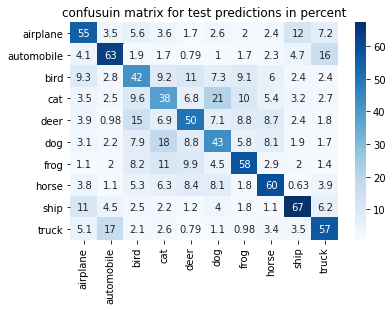

Macro precision: 0.5346
Macro recall: 0.5369
Accuracy: 53.69 %


In [ ]:
eval_model(model)

# Plain12 tangh

Early stopping
epochs: 29


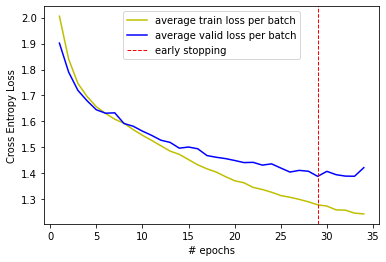

--- 8.503853579362234 minuts ---


In [ ]:
model_name = 'Plain12_tangh'
class Plain12_tangh(nn.Module):
  def __init__(self):
    super(Plain12_tangh,self).__init__()
    self.conv1 = nn.Conv2d(3, 8, 4, padding=1,stride=2, bias=False)
    self.conv2 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv3 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv4 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv5 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv6 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv7 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv8 = nn.Conv2d(8, 16, 3, padding=1, bias=False)
    self.conv9 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.conv10 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.conv11 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*16,10)
  def forward(self, x):
    x = torch.tanh(self.conv1(x))
    x = torch.tanh(self.conv2(x)) 
    x = torch.tanh(self.conv3(x))
    x = torch.tanh(self.conv4(x))
    x = torch.tanh(self.conv5(x))
    x = torch.tanh(self.conv6(x))
    x = torch.tanh(self.conv7(x))
    x = torch.tanh(self.conv8(x))
    x = torch.tanh(self.conv9(x))
    x = torch.tanh(self.conv10(x))
    x = torch.tanh(self.conv11(x))
    x = self.avpool(x)
    x = x.view(-1,8*8*16)
    x = self.fc1(x)
    return x #10 class scores

model =Plain12_tangh()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

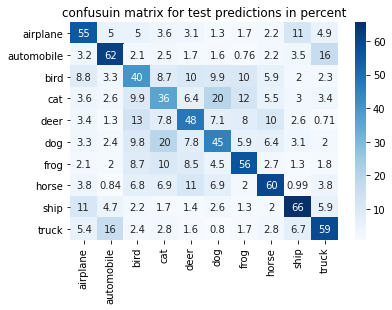

Macro precision: 0.5277
Macro recall: 0.5304
Accuracy: 53.04 %


In [ ]:
eval_model(model)

# Plain9 tangh

Early stopping
epochs: 50


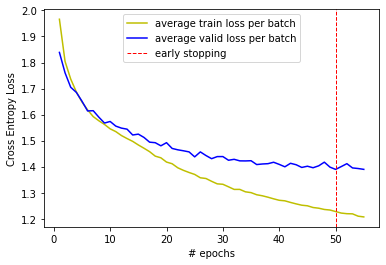

--- 12.989149113496145 minuts ---


In [ ]:
model_name = 'Plain9_tangh'
class Plain9_tangh(nn.Module):
  def __init__(self):
    super(Plain9_tangh,self).__init__()
    self.conv1 = nn.Conv2d(3, 8, 4, padding=1,stride=2, bias=False)
    self.conv2 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv3 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv4 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv5 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv6 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv7 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv8 = nn.Conv2d(8, 16, 3, padding=1, bias=False)
    # self.conv9 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    # self.conv10 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    # self.conv11 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*16,10)
  def forward(self, x):
    x = torch.tanh(self.conv1(x))
    x = torch.tanh(self.conv2(x)) 
    x = torch.tanh(self.conv3(x))
    x = torch.tanh(self.conv4(x))
    x = torch.tanh(self.conv5(x))
    x = torch.tanh(self.conv6(x))
    x = torch.tanh(self.conv7(x))
    x = torch.tanh(self.conv8(x))
    # x = torch.tanh(self.conv9(x))
    # x = torch.tanh(self.conv10(x))
    # x = torch.tanh(self.conv11(x))
    x = self.avpool(x)
    x = x.view(-1,8*8*16)
    x = self.fc1(x)
    return x #10 class scores

model =Plain9_tangh()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

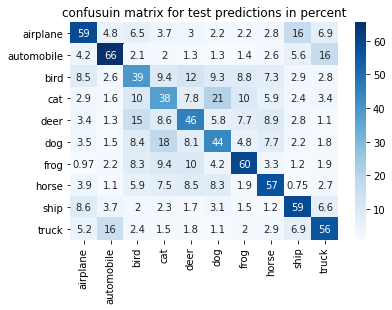

Macro precision: 0.5230
Macro recall: 0.5244
Accuracy: 52.44 %


In [ ]:
eval_model(model)

# ResNet12 Overfitting

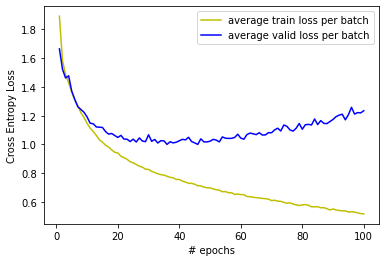

--- 29.75595206419627 minuts ---


In [ ]:
model_name = 'ResNet12_overfitting'
class ResNet12(nn.Module):
  def __init__(self):
    super(ResNet12,self).__init__()
    self.conv1 = nn.Conv2d(3, 4, 4, padding=1,stride=2, bias=False)
    self.conv2 = nn.Conv2d(4, 4, 3, padding=1, bias=False)
    self.conv3 = nn.Conv2d(4, 4, 3, padding=1, bias=False)
    self.conv4 = nn.Conv2d(4, 8, 3, padding=1, bias=False)
    self.conv5 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv6 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv7 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv8 = nn.Conv2d(8, 16, 3, padding=1, bias=False)
    self.conv9 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.conv10 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.conv11 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*16,10)
  def forward(self, x):
    padding_zeros_4 = torch.zeros(batch_size,4,16,16).to(device)
    padding_zeros_8 = torch.zeros(batch_size,8,16,16).to(device)
    x = self.conv1(x) #4*16*16
    identity = x.clone()
    x = F.relu(x)
    x = F.relu(self.conv2(x)) 
    x = self.conv3(x)
    x = x + identity
    identity = x.clone()
    x = F.relu(x)
    x = F.relu(self.conv4(x)) #8*16*16
    x = self.conv5(x) 
    x = x + torch.cat([identity,padding_zeros_4],axis=1)
    identity = x.clone()
    x = F.relu(x)
    x = F.relu(self.conv6(x)) 
    x = self.conv7(x)
    x = x + identity
    identity = x.clone() 
    x = F.relu(x)
    x = F.relu(self.conv8(x)) #16
    x = self.conv9(x) 
    x = x + torch.cat([identity,padding_zeros_8],axis=1)
    identity = x.clone() 
    x = F.relu(x)
    x = F.relu(self.conv10(x))
    x = self.conv11(x)
    x = x+identity
    x = F.relu(x)
    x = self.avpool(x)
    x = x.view(-1,8*8*16)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet12()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

start_time = time.time()

num_epochs = 100
# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = [] 
for epoch in range(1, num_epochs + 1):
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for batch, (data, target) in enumerate(train_loader, 1):
        data = data.to(device)
        target = target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # record training loss
        train_losses.append(loss.item())

    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    with torch.no_grad():
      for data, target in valid_loader:
          data = data.to(device)
          target = target.to(device)
          # forward pass: compute predicted outputs by passing inputs to the model
          output = model(data)
          # calculate the loss
          loss = criterion(output, target)
          # record validation loss
          valid_losses.append(loss.item())

    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    # clear lists to track next epoch
    train_losses = []
    valid_losses = []

    torch.save(model.state_dict(), save_to+model_name+'_'+str(epoch))

# plot learning curves
plt.plot(range(1,num_epochs+1),avg_train_losses,'y',label = 'average train loss per batch')
plt.plot(range(1,num_epochs+1),avg_valid_losses,'b', label = 'average valid loss per batch')   
plt.xlabel('# epochs')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

print("--- %s minuts ---" % ((time.time() - start_time)/60))

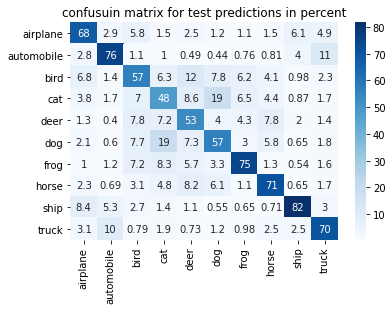

Macro precision: 0.6578
Macro recall: 0.6557
Accuracy: 65.57 %


In [ ]:
eval_model(model)

# ResNet12 wide

Early stopping
epochs: 6


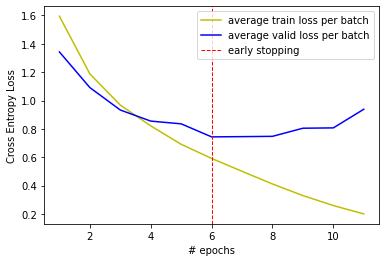

--- 11.906316574414571 minuts ---


In [ ]:
model_name = 'ResNet12_wide'
class ResNet12(nn.Module):
  def __init__(self):
    super(ResNet12,self).__init__()
    self.conv1 = nn.Conv2d(3, 64, 4, padding=1,stride=2, bias=False)
    self.conv2 = nn.Conv2d(64, 64, 3, padding=1, bias=False)
    self.conv3 = nn.Conv2d(64, 64, 3, padding=1, bias=False)
    self.conv4 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
    self.conv5 = nn.Conv2d(128, 128, 3, padding=1, bias=False)
    self.conv6 = nn.Conv2d(128, 128, 3, padding=1, bias=False)
    self.conv7 = nn.Conv2d(128, 128, 3, padding=1, bias=False)
    self.conv8 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
    self.conv9 = nn.Conv2d(256, 256, 3, padding=1, bias=False)
    self.conv10 = nn.Conv2d(256, 256, 3, padding=1, bias=False)
    self.conv11 = nn.Conv2d(256, 256, 3, padding=1, bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*256,10)
  def forward(self, x):
    padding_zeros_64 = torch.zeros(batch_size,64,16,16).to(device)
    padding_zeros_128 = torch.zeros(batch_size,128,16,16).to(device)
    x = self.conv1(x) #64*16*16
    identity = x.clone()
    x = F.relu(x)
    x = F.relu(self.conv2(x)) 
    x = self.conv3(x)
    x = x + identity
    identity = x.clone()
    x = F.relu(x)
    x = F.relu(self.conv4(x)) #128*16*16
    x = self.conv5(x) 
    x = x + torch.cat([identity,padding_zeros_64],axis=1)
    identity = x.clone()
    x = F.relu(x)
    x = F.relu(self.conv6(x)) 
    x = self.conv7(x)
    x = x + identity
    identity = x.clone() 
    x = F.relu(x)
    x = F.relu(self.conv8(x)) #256
    x = self.conv9(x) 
    x = x + torch.cat([identity,padding_zeros_128],axis=1)
    identity = x.clone() 
    x = F.relu(x)
    x = F.relu(self.conv10(x))
    x = self.conv11(x)
    x = x+identity
    x = F.relu(x)
    x = self.avpool(x)
    x = x.view(-1,8*8*256)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet12()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0005)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

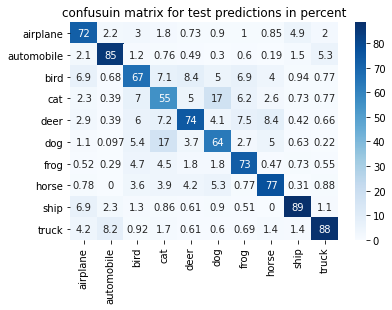

Macro precision: 0.7450
Macro recall: 0.7431
Accuracy: 74.31 %


In [ ]:
eval_model(model)

# Plain12 wide

In [ ]:
model_name = 'Plain12_wide'
class Plain12(nn.Module):
  def __init__(self):
    super(Plain12,self).__init__()
    self.conv1 = nn.Conv2d(3, 64, 4, padding=1,stride=2, bias=False)
    self.conv2 = nn.Conv2d(64, 64, 3, padding=1, bias=False)
    self.conv3 = nn.Conv2d(64, 64, 3, padding=1, bias=False)
    self.conv4 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
    self.conv5 = nn.Conv2d(128, 128, 3, padding=1, bias=False)
    self.conv6 = nn.Conv2d(128, 128, 3, padding=1, bias=False)
    self.conv7 = nn.Conv2d(128, 128, 3, padding=1, bias=False)
    self.conv8 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
    self.conv9 = nn.Conv2d(256, 256, 3, padding=1, bias=False)
    self.conv10 = nn.Conv2d(256, 256, 3, padding=1, bias=False)
    self.conv11 = nn.Conv2d(256, 256, 3, padding=1, bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*256,10)
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x)) 
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = F.relu(self.conv7(x))
    x = F.relu(self.conv8(x))
    x = F.relu(self.conv9(x))
    x = F.relu(self.conv10(x))
    x = F.relu(self.conv11(x))
    x = self.avpool(x)
    x = x.view(-1,8*8*256)
    x = self.fc1(x)
    return x #10 class scores

model = Plain12()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0005)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

KeyboardInterrupt: ignored

In [ ]:
eval_model(model)